In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, multilabel_confusion_matrix, mean_absolute_error, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pprint
import random
from scipy import stats
from sklearn import svm
from xgboost import XGBRegressor

Baseline Predictor

In [ ]:
og_df = pd.read_csv('/content/new_inflated_response_time_prepped_for_visualization.csv')

baseline_df = pd.DataFrame(columns=['DNN-1', 'Rate', 'Processors', 'Memory', 'UL-1', 'Baseline-Response'])

baseline_df['DNN-1'] = og_df['DNN-1']
baseline_df['Rate'] = og_df['Rate']
baseline_df['Processors'] = og_df['Processors']
baseline_df['Memory'] = og_df['Memory']
baseline_df['UL-1'] = og_df['UL-1']
baseline_df['Baseline-Response'] = og_df['Baseline-Response']

baseline_df.drop_duplicates(subset=['DNN-1', 'Rate', 'Memory', 'Processors', 'Baseline-Response', 'UL-1'], keep='first', inplace=True)

# # train baseline response time prediction model
selected_columns = ['DNN-1', 'Rate', 'Processors', 'Memory', 'UL-1']
X = baseline_df[selected_columns]
y = baseline_df[['Baseline-Response']]

string_encoder = preprocessing.LabelEncoder()
X['DNN-1'] = string_encoder.fit_transform(X['DNN-1'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

dt_regressor = DecisionTreeRegressor(random_state=0)

dt_regressor.fit(X_train, y_train)
y_pred = dt_regressor.predict(X_test)

param_grid = {
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 7, 10],
    "min_samples_leaf": [1, 2, 3, 5],
    "max_features": [None, "auto", "sqrt", "log2"]
}

def perform_grid_search():
  grid_search = GridSearchCV(dt_regressor, param_grid, cv=3, n_jobs=-1)
  grid_search.fit(X_train, y_train)
  print("Best Parameters:", grid_search.best_params_)
  print("Best Score:", grid_search.best_score_)

# perform_grid_search()

results_df = pd.DataFrame(columns=['Actual', 'Predicted', 'MAE', 'Relative Error'])
results_df['Actual'] = y_test
results_df['Predicted'] = y_pred
results_df['MAE'] = abs(results_df['Actual'] - results_df['Predicted'])
results_df['Relative Error'] = results_df['MAE']/results_df['Actual']
print(np.mean(results_df['Relative Error']))


Baseline Prediction (Unseen)

In [ ]:
og_df = pd.read_csv('/content/new_inflated_response_time_prepped_for_visualization.csv')

baseline_df = pd.DataFrame(columns=['DNN-1', 'Rate', 'Processors', 'Memory', 'UL-1', 'Baseline-Response'])

baseline_df['DNN-1'] = og_df['DNN-1']
baseline_df['Rate'] = og_df['Rate']
baseline_df['Processors'] = og_df['Processors']
baseline_df['Memory'] = og_df['Memory']
baseline_df['UL-1'] = og_df['UL-1']
baseline_df['Baseline-Response'] = og_df['Baseline-Response']

baseline_df.drop_duplicates(subset=['DNN-1', 'Rate', 'Memory', 'Processors', 'UL-1', 'Baseline-Response'], keep='first', inplace=True)

# # train baseline response time prediction model
selected_columns = ['DNN-1', 'Rate', 'Processors', 'Memory', 'UL-1']

# training_df = baseline_df[(baseline_df['Rate'] <= 16)]
# testing_df = baseline_df[(baseline_df['Rate'] > 16)]

# training_df = baseline_df[(baseline_df['Rate'] <= 4) | ((baseline_df['Rate'] >= 10) & (baseline_df['Rate'] <= 12)) | (baseline_df['Rate'] >= 18)]
# testing_df = baseline_df[((baseline_df['Rate'] > 4) & (baseline_df['Rate'] < 10)) | ((baseline_df['Rate'] > 12) & (baseline_df['Rate'] < 18))]

training_df = baseline_df[(baseline_df['Rate'] <= 6) | (baseline_df['Rate'] == 10) | (baseline_df['Rate'] == 14) | (baseline_df['Rate'] == 18)]
testing_df = baseline_df[(baseline_df['Rate'] >= 8) & (baseline_df['Rate'] != 10) & (baseline_df['Rate'] != 16) & (baseline_df['Rate'] != 20)]

X_train = training_df[selected_columns]
y_train = training_df[['Baseline-Response']]

X_test = testing_df[selected_columns]
y_test = testing_df[['Baseline-Response']]

string_encoder = preprocessing.LabelEncoder()
X_train['DNN-1'] = string_encoder.fit_transform(X_train['DNN-1'])
X_test['DNN-1'] = string_encoder.fit_transform(X_test['DNN-1'])

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

dt_regressor = DecisionTreeRegressor()

dt_regressor.fit(X_train, y_train)
y_pred = dt_regressor.predict(X_test)

results_df = pd.DataFrame(columns=['Actual', 'Predicted', 'MAE', 'Relative Error'])
results_df['Actual'] = y_test
results_df['Predicted'] = y_pred
results_df['MAE'] = abs(results_df['Actual'] - results_df['Predicted'])
results_df['Relative Error'] = results_df['MAE']/results_df['Actual']
print(np.mean(results_df['Relative Error']))
results_df

Multi-label Classification (General)

In [ ]:
df = pd.read_csv('/content/new_inflated_response_time_prepped_for_visualization.csv')

selected_columns = ['DNN-1', 'DNN-2', 'Rate', 'Processors', 'Memory',  \
                    'Baseline-Response', 'Baseline-Sum', 'Baseline-DNN-2', 'UL-1', 'UL-2']

X = df[selected_columns]

# function to predict baseline response time
def predict_baseline(dnn, rate, processors, memory, ul, baseline_response):
  if (rate <= 6 or rate == 10 or rate == 14 or rate == 18):
    return baseline_response
  else:
    return dt_regressor.predict(np.array([dnn, rate, processors, memory, ul]).reshape(1,-1))[0]


string_encoder = preprocessing.LabelEncoder()
X['DNN-1'] = string_encoder.fit_transform(X['DNN-1'])
X['DNN-2'] = string_encoder.fit_transform(X['DNN-2'])

X['Baseline-Response'] = X.apply(lambda row: predict_baseline(row['DNN-1'], row['Rate'], row['Processors'], row['Memory'], row['UL-1'], row['Baseline-Response']), axis=1)
X['Baseline-DNN-2'] = X.apply(lambda row: predict_baseline(row['DNN-2'], row['Rate'], row['Processors'], row['Memory'], row['UL-2'], row['Baseline-DNN-2']), axis=1)
X['Baseline-Sum'] = X['Baseline-Response'] + X['Baseline-DNN-2']

X.drop(['Baseline-DNN-2'], axis=1, inplace=True)
y = df[['SLA_Level_1', 'SLA_Level_2','SLA_Level_3', 'All_SLA_Levels_Violated']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Feature scaling (optional but often recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

multi_target_rf = MultiOutputClassifier(rf_classifier, n_jobs=-1)

multi_target_rf.fit(X_train, y_train)

y_pred = multi_target_rf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['SLA_Level_1', 'SLA_Level_2','SLA_Level_3', 'All_SLA_Levels_Violated']))

print("Confusion Matrices and Accuracy Score for Each Label")
print('SLA Level 1 for Thin Container Setting')
print(multilabel_confusion_matrix(y_test, y_pred)[0])
print('SLA Level 2 for Thin Container Setting')
print(multilabel_confusion_matrix(y_test, y_pred)[1])
print('SLA Level 3 for Thin Container Setting')
print(multilabel_confusion_matrix(y_test, y_pred)[2])
print('All SLA Levels Violated for Thin Container Setting')
print(multilabel_confusion_matrix(y_test, y_pred)[3])

print('Accuracy: ', accuracy_score(y_test, y_pred))


def perform_grid_search():
  rf_classifier = RandomForestClassifier(random_state=42)
  multi_target_rf = MultiOutputClassifier(rf_classifier, n_jobs=-1)

  param_grid = {
    "estimator__n_estimators": [50, 75, 100, 150, 200],
    "estimator__max_depth": [None, 10, 20],
    "estimator__min_samples_split": [2, 3, 5, 10]}

  grid_search = GridSearchCV(multi_target_rf, param_grid, cv=3, n_jobs=-1)
  grid_search.fit(X_train, y_train)
  print("Best Parameters:", grid_search.best_params_)
  y_pred = grid_search.predict(X_test)
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))
  print('Accuracy: ', accuracy_score(y_test, y_pred))

# perform_grid_search()

f, axes = plt.subplots(1, 3, figsize=(8, 3))
axes = axes.ravel()
for i in range(3):
    disp = ConfusionMatrixDisplay(multilabel_confusion_matrix(y_test, y_pred)[i],
                                  display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g')
    if i != 3:
        disp.ax_.set_title(f'SLA Level {i+1}')
    else:
        disp.ax_.set_title(f'All SLA Levels Violated')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.35, hspace=0.35)
f.colorbar(disp.im_, ax=axes)
# plt.show()
plt.savefig('cnsm-image-confusion-matrix.png', dpi=600)

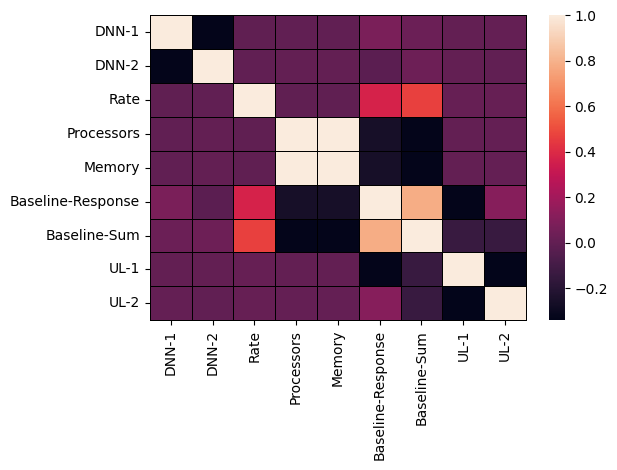

In [ ]:
corr_matrix = X.corr()
# round(corr_matrix,2)
sns.heatmap(corr_matrix, linewidths=0.5, linecolor='black', clip_on=False)
plt.tight_layout()
plt.savefig('cnsm-image-correlation-matrix.png', dpi=600)

Multi-label Classification (Unseen Resource Settings)


In [ ]:
df = pd.read_csv('/content/new_inflated_response_time_prepped_for_visualization.csv')

selected_columns = ['DNN-1', 'DNN-2', 'Rate', 'Processors', 'Memory',  \
                    'Baseline-Response', 'Baseline-Sum', 'Baseline-DNN-2', 'UL-1', 'UL-2']

# function to predict baseline response time
def predict_baseline(dnn, rate, processors, memory, ul, baseline_response):
  if (rate <= 6 or rate == 10 or rate == 14 or rate == 18):
    return baseline_response
  else:
    return dt_regressor.predict(np.array([dnn, rate, processors, memory, ul]).reshape(1,-1))[0]

# training_df = df[(df['Rate'] <= 16)]
# testing_df = df[(df['Rate'] > 16)]

# hold out resources
training_df = df[(df['Processors'] != 6) & (df['Memory'] != 6)]
testing_df = df[(df['Processors'] == 6) & (df['Memory'] == 6)]

X_train = training_df[selected_columns]
y_train = training_df[['SLA_Level_1', 'SLA_Level_2','SLA_Level_3', 'All_SLA_Levels_Violated']]

X_test = testing_df[selected_columns]
y_test = testing_df[['SLA_Level_1', 'SLA_Level_2','SLA_Level_3', 'All_SLA_Levels_Violated']]

string_encoder = preprocessing.LabelEncoder()
X_train['DNN-1'] = string_encoder.fit_transform(X_train['DNN-1'])
X_train['DNN-2'] = string_encoder.fit_transform(X_train['DNN-2'])
X_test['DNN-1'] = string_encoder.fit_transform(X_test['DNN-1'])
X_test['DNN-2'] = string_encoder.fit_transform(X_test['DNN-2'])

X_train['Baseline-Response'] = X_train.apply(lambda row: predict_baseline(row['DNN-1'], row['Rate'], row['Processors'], row['Memory'], row['UL-1'], row['Baseline-Response']), axis=1)
X_train['Baseline-DNN-2'] = X_train.apply(lambda row: predict_baseline(row['DNN-2'], row['Rate'], row['Processors'], row['Memory'], row['UL-2'], row['Baseline-DNN-2']), axis=1)
X_train['Baseline-Sum'] = X_train['Baseline-Response'] + X_train['Baseline-DNN-2']

X_test['Baseline-Response'] = X_test.apply(lambda row: predict_baseline(row['DNN-1'], row['Rate'], row['Processors'], row['Memory'], row['UL-1'], row['Baseline-Response']), axis=1)
X_test['Baseline-DNN-2'] = X_test.apply(lambda row: predict_baseline(row['DNN-2'], row['Rate'], row['Processors'], row['Memory'], row['UL-2'], row['Baseline-DNN-2']), axis=1)
X_test['Baseline-Sum'] = X_test['Baseline-Response'] + X_test['Baseline-DNN-2']

X_train.drop(['Baseline-DNN-2'], axis=1, inplace=True)
X_test.drop(['Baseline-DNN-2'], axis=1, inplace=True)



# hold out rates

# training_df = df[(df['Rate'] <= 4) | ((df['Rate'] >= 10) & (df['Rate'] <= 12)) | (df['Rate'] >= 18)]
# testing_df = df[((df['Rate'] > 4) & (df['Rate'] < 10)) | ((df['Rate'] > 12) & (df['Rate'] < 18))]

# training_df = df[(df['Rate'] <= 6) | ((df['Rate'] >= 10) & (df['Rate'] <= 16))]
# testing_df = df[((df['Rate'] > 6) & (df['Rate'] < 10)) | (df['Rate'] > 16)]

# hold out rates and resources
# training_df = df[(df['Processors'] != 6) & (df['Rate'] <= 16)]
# testing_df = df[(df['Processors'] == 6) & (df['Rate'] > 16)]

# Feature scaling (optional but often recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

multi_target_rf = MultiOutputClassifier(rf_classifier, n_jobs=-1)

multi_target_rf.fit(X_train, y_train)

y_pred = multi_target_rf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['SLA_Level_1', 'SLA_Level_2','SLA_Level_3', 'All_SLA_Levels_Violated']))



print("Confusion Matrices and Accuracy Score for Each Label")
print('SLA Level 1 for Thin Container Setting')
print(multilabel_confusion_matrix(y_test, y_pred)[0])
print('SLA Level 2 for Thin Container Setting')
print(multilabel_confusion_matrix(y_test, y_pred)[1])
print('SLA Level 3 for Thin Container Setting')
print(multilabel_confusion_matrix(y_test, y_pred)[2])
print('All SLA Levels Violated for Thin Container Setting')
print(multilabel_confusion_matrix(y_test, y_pred)[3])

print('Accuracy: ', accuracy_score(y_test, y_pred))

def perform_grid_search():
  rf_classifier = RandomForestClassifier(random_state=42)
  multi_target_rf = MultiOutputClassifier(rf_classifier, n_jobs=-1)

  param_grid = {
    "estimator__n_estimators": [50, 75, 100, 150, 200],
    "estimator__max_depth": [None, 10, 20],
    "estimator__min_samples_split": [2, 3, 5, 10]}

  grid_search = GridSearchCV(multi_target_rf, param_grid, cv=3, n_jobs=-1)
  grid_search.fit(X_train, y_train)
  print("Best Parameters:", grid_search.best_params_)
  y_pred = grid_search.predict(X_test)
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))
  print('Accuracy: ', accuracy_score(y_test, y_pred))

# perform_grid_search()

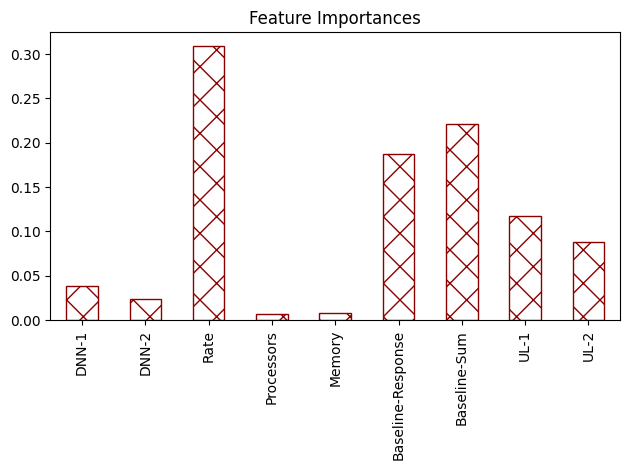

In [ ]:
importances = multi_target_rf.estimators_[0].feature_importances_

forest_importances = pd.Series(importances, index=selected_columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax, edgecolor='darkred', color='white',  hatch='x')
ax.set_title("Feature Importances")
fig.tight_layout()
plt.savefig('cnsm-image-feature-importances.png', dpi=300)

Multi-label Classification (Unseen Workloads)

In [ ]:
df = pd.read_csv('/content/new_inflated_response_time_prepped_for_visualization.csv')

selected_columns = ['DNN-1', 'DNN-2', 'Rate', 'Processors', 'Memory',  \
                    'Baseline-Response', 'Baseline-Sum', 'Baseline-DNN-2', 'UL-1', 'UL-2']

def predict_baseline(dnn, rate, processors, memory, ul, baseline_response):
  if (rate <= 6 or rate == 10 or rate == 14 or rate == 18):
    return baseline_response
  else:
    return dt_regressor.predict(np.array([dnn, rate, processors, memory, ul]).reshape(1,-1))[0]

# hold out resources
# training_df = df[(df['cores'] != 6) & (df['memory'] != 6)]
# testing_df = df[(df['cores'] == 6) & (df['memory'] == 6)]

# hold out higher rates
# training_df = df[(df['Rate'] <= 16)]
# testing_df = df[(df['Rate'] > 16)]

# hold out partial rates
# training_df = df[(df['Rate'] <= 6) | ((df['Rate'] >= 10) & (df['Rate'] <= 16))]
# testing_df = df[((df['Rate'] > 6) & (df['Rate'] < 10)) | (df['Rate'] > 16)]

# training_df = df[(df['Rate'] <= 4) | ((df['Rate'] >= 10) & (df['Rate'] <= 12)) | (df['Rate'] >= 18)]
# testing_df = df[((df['Rate'] > 4) & (df['Rate'] < 10)) | ((df['Rate'] > 12) & (df['Rate'] < 18))]

# hold out a utilization level
# training_df = df[(df['model_1_utilization'] != 4)]
# testing_df = df[(df['model_1_utilization'] == 4)]

# training_df = df[(df['model_2_utilization'] != 4)]
# testing_df = df[(df['model_2_utilization'] == 4)]

# hold out higher rates and mid resources
# training_df = df[(df['Rate'] <= 16) & (df['Processors'] != 12)]
# testing_df = df[(df['Rate'] > 16) & (df['Processors'] == 12)]

training_df = df[((((df['DNN-1'] != 'bert') & (df['DNN-2'] != 'dbert')) | ((df['DNN-1'] != 'dbert') & (df['DNN-2'] != 'bert'))) & (df['Rate'] < 18))]
testing_df = df[((((df['DNN-1'] == 'bert') & (df['DNN-2'] == 'dbert')) | ((df['DNN-2'] == 'dbert') & (df['DNN-2'] == 'bert'))) & (df['Rate'] >= 18))]

X_train = training_df[selected_columns]
y_train = training_df[['SLA_Level_1', 'SLA_Level_2','SLA_Level_3', 'All_SLA_Levels_Violated']]

X_test = testing_df[selected_columns]
y_test = testing_df[['SLA_Level_1', 'SLA_Level_2','SLA_Level_3', 'All_SLA_Levels_Violated']]

string_encoder = preprocessing.LabelEncoder()
X_train['DNN-1'] = string_encoder.fit_transform(X_train['DNN-1'])
X_train['DNN-2'] = string_encoder.fit_transform(X_train['DNN-2'])
X_test['DNN-1'] = string_encoder.fit_transform(X_test['DNN-1'])
X_test['DNN-2'] = string_encoder.fit_transform(X_test['DNN-2'])

X_train['Baseline-Response'] = X_train.apply(lambda row: predict_baseline(row['DNN-1'], row['Rate'], row['Processors'], row['Memory'], row['UL-1'], row['Baseline-Response']), axis=1)
X_train['Baseline-DNN-2'] = X_train.apply(lambda row: predict_baseline(row['DNN-2'], row['Rate'], row['Processors'], row['Memory'], row['UL-2'], row['Baseline-DNN-2']), axis=1)
X_train['Baseline-Sum'] = X_train['Baseline-Response'] + X_train['Baseline-DNN-2']

X_test['Baseline-Response'] = X_test.apply(lambda row: predict_baseline(row['DNN-1'], row['Rate'], row['Processors'], row['Memory'], row['UL-1'], row['Baseline-Response']), axis=1)
X_test['Baseline-DNN-2'] = X_test.apply(lambda row: predict_baseline(row['DNN-2'], row['Rate'], row['Processors'], row['Memory'], row['UL-2'], row['Baseline-DNN-2']), axis=1)
X_test['Baseline-Sum'] = X_test['Baseline-Response'] + X_test['Baseline-DNN-2']

X_train.drop(['Baseline-DNN-2'], axis=1, inplace=True)
X_test.drop(['Baseline-DNN-2'], axis=1, inplace=True)

# Feature scaling (optional but often recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

multi_target_rf = MultiOutputClassifier(rf_classifier, n_jobs=-1)

multi_target_rf.fit(X_train, y_train)

y_pred = multi_target_rf.predict(X_test)

print("Classification Report:")

print(classification_report(y_test, y_pred, target_names=['sla_level_1_thin', \
                                                          'sla_level_2_thin','sla_level_3_thin', \
                                                          'all_sla_levels_violated']))


print("Confusion Matrices and Accuracy Score for Each Label")
print('SLA Level 1 for Thin Container Setting')
print(multilabel_confusion_matrix(y_test, y_pred)[0])
print('SLA Level 2 for Thin Container Setting')
print(multilabel_confusion_matrix(y_test, y_pred)[1])
print('SLA Level 3 for Thin Container Setting')
print(multilabel_confusion_matrix(y_test, y_pred)[2])
print('All SLA Levels Violated for Thin Container Setting')
print(multilabel_confusion_matrix(y_test, y_pred)[3])

print('Accuracy: ', accuracy_score(y_test, y_pred))

def perform_grid_search():
  rf_classifier = RandomForestClassifier(random_state=42)
  multi_target_rf = MultiOutputClassifier(rf_classifier, n_jobs=-1)

  param_grid = {
    "estimator__n_estimators": [50, 75, 100, 150, 200],
    "estimator__max_depth": [None, 10, 20],
    "estimator__min_samples_split": [2, 3, 5, 10]}

  grid_search = GridSearchCV(multi_target_rf, param_grid, cv=3, n_jobs=-1)
  grid_search.fit(X_train, y_train)
  print("Best Parameters:", grid_search.best_params_)
  y_pred = grid_search.predict(X_test)
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))
  print('Accuracy: ', accuracy_score(y_test, y_pred))

# perform_grid_search()